K	DB Index	Silhouette Score
--------------------------------------------------
2	1.7082		0.2170
3	1.7221		0.2198
4	1.3266		0.3062
5	0.9742		0.3959
6	0.9735		0.3779
7	0.9115		0.4031
8	0.8713		0.4166
9	0.9315		0.3897
10	0.9948		0.3587

Optimal K based on the lowest DB Index: 8
Lowest DB Index: 0.8713


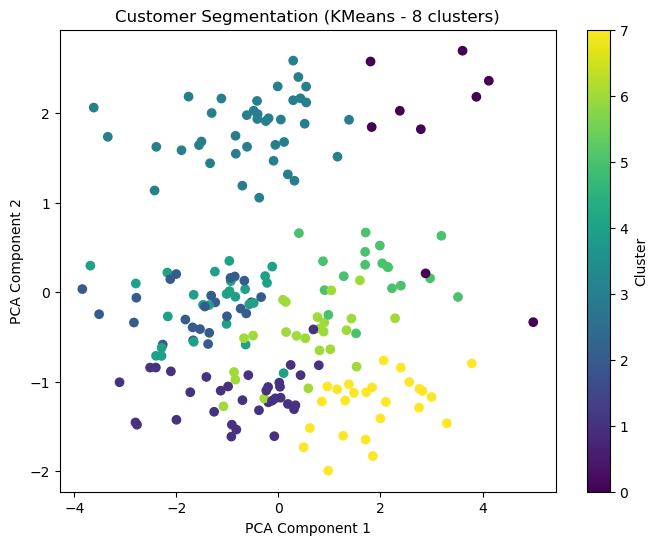

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Step 1: Load the customer and transaction data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Step 2: Aggregate transaction data by CustomerID
transaction_agg = transactions_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    avg_spend_per_transaction=('TotalValue', 'mean'),
    transaction_count=('TransactionID', 'count')
).reset_index()

# Step 3: Merge the customer profile and aggregated transaction data
merged_df = pd.merge(customers_df, transaction_agg, on='CustomerID')

# Step 4: One-Hot Encoding for Region
region_dummies = pd.get_dummies(merged_df['Region'], prefix='Region')
merged_df = pd.concat([merged_df, region_dummies], axis=1)

# Drop unnecessary columns (e.g., 'Region', 'CustomerName', 'SignupDate')
merged_df.drop(columns=['Region', 'CustomerName', 'SignupDate'], inplace=True)

# Step 5: Standardize the features
features = merged_df.drop(columns=['CustomerID'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 6: Evaluate clustering for different numbers of clusters (2 to 10)
db_index_values = []
silhouette_values = []

print("K\tDB Index\tSilhouette Score")
print("-" * 50)

for n_clusters in range(2, 11):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    
    # Get the cluster labels
    labels = kmeans.labels_
    
    # Compute DB Index
    db_index = davies_bouldin_score(scaled_features, labels)
    db_index_values.append(db_index)
    
    # Compute Silhouette Score
    silhouette = silhouette_score(scaled_features, labels)
    silhouette_values.append(silhouette)
    
    
    # Print the metrics for the current number of clusters
    print(f"{n_clusters}\t{db_index:.4f}\t\t{silhouette:.4f}")

# Find the optimal K based on the lowest DB Index
optimal_k_db = 2 + db_index_values.index(min(db_index_values))  # Add 2 since K starts at 2
print(f"\nOptimal K based on the lowest DB Index: {optimal_k_db}")
print(f"Lowest DB Index: {min(db_index_values):.4f}")

# Step 7: Apply KMeans clustering with the optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_k_db, random_state=42)
final_labels = final_kmeans.fit_predict(scaled_features)

# Step 8: Visualize the clusters using PCA for 2D representation
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot the clusters in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=final_labels, cmap='viridis')
plt.title(f'Customer Segmentation (KMeans - {optimal_k_db} clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Step 9: Save the final clustering results
merged_df['Cluster'] = final_labels

# Ou


#### The results show that the optimal number of clusters is 8, as it has the lowest Davies-Bouldin Index of 0.8713, indicating well-separated and compact clusters. The Silhouette Score for this choice is 0.4166, which is also relatively good compared to the other cluster sizes.